In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pyemma
from pyemma.util.contexts import settings
import pyemma.coordinates as coor

In [6]:
trajfile = []
for i in range(1,6):
    path = '/net/jam-amaro-shared/bccgc4/Strided_Traj/joined_traj_md'+str(i)+'.nc'
    trajfile.append(path)

top = "/net/jam-amaro-shared/bccgc4/Strided_Traj/protein.h5"

#assigns the features

torsions_feat = coor.featurizer(top)
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = coor.load(trajfile, torsions_feat)
labels = ['backbone\ntorsions']

positions_feat = coor.featurizer(top)
positions_feat.add_selection(positions_feat.select_Backbone())
positions_data = coor.load(trajfile, positions_feat)
labels += ['backbone atom\npositions']

receptor = coor.featurizer(top)
receptor.add_selection([1024, 1027, 306, 1029, 1031, 1033, 2851, 1035, 1036, 1037, 1038, 1039, 1034, 1040, 1042, 1043, 1044, 1045, 1041, 2854, 1049, 2076, 311, 1060, 1061, 1062,
                              1072, 1074, 1076, 1087, 2112, 2116, 2120, 2122, 2123, 2126, 2135, 323, 2138, 324, 325, 1133, 1134, 1135, 1136, 1137, 2170, 330, 3206, 3207, 3208, 3210, 3323, 
                              334, 3219, 336, 2207, 2209, 2210, 2211, 2213, 2214, 2215, 2217, 2219, 2220, 2221, 3244, 1715, 1716, 1743, 1745, 1747, 1749, 2897, 3312, 3313, 3314, 3315, 3316, 
                              3317, 3318, 3319, 3320, 3321, 3322, 2837, 328, 329, 2899, 339, 342, 343, 350, 2911, 354, 359, 361, 362, 363, 364, 365, 366, 367, 379, 385, 386, 395, 398, 2449, 
                              2451, 2452, 2453, 2454, 2455, 2456, 2460, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2477, 2478, 941, 2480, 2481, 946, 2834, 944, 2486, 
                              2487, 2488, 2835, 2492, 2836, 2494, 963, 2838, 2506, 2507, 2508, 2839, 2510, 972, 978, 979, 980, 2841, 2842, 2844, 997, 2845, 1003, 2846, 1008, 1007, 1010, 
                              1009, 2847, 1012, 1013, 1011, 1016, 1017, 1018, 1022])
receptor_data = coor.load(trajfile, receptor)
labels += ['Receptor\nAtoms']
#residues = coor.featurizer(top)
#residues.add_residue_mindist([[146,187],[116,136],[142,143],[71,212],[27,29],[117,187],[64,160],[119,20],[216,191],[24,146],[114,119]], scheme="closest-heavy")
#print(residues.describe()[:13])
#residue_data = coor.load(trajfile, residues)
#labels += ['Residue\ndistances']

#distances_feat = coor.featurizer(top)
#distances_feat.add_distances(
#    distances_feat.pairs(distances_feat.select_Backbone(), excluded_neighbors=2), periodic=False)
#distances_data = coor.load(trajfile, distances_feat)
#labels += ['backbone atom\ndistances']

#print('trajectory length = ',torsions_data.trajectory_length(0))
#print('number of dimension = ',torsions_data.dimension())

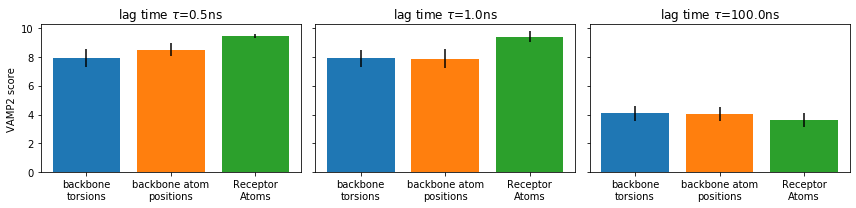

In [7]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
    """Compute a cross-validated VAMP2 score.

    We randomly split the list of independent trajectories into
    a training and a validation set, compute the VAMP2 score,
    and repeat this process several times.

    Parameters
    ----------
    data : list of numpy.ndarrays
        The input data.
    dim : int
        Number of processes to score; equivalent to the dimension
        after projecting the data with VAMP2.
    lag : int
        Lag time for the VAMP2 scoring.
    number_of_splits : int, optional, default=10
        How often do we repeat the splitting and score calculation.
    validation_fraction : int, optional, default=0.5
        Fraction of trajectories which should go into the validation
        set during a split.
    """
    # we temporarily suppress very short-lived progress bars
    with pyemma.util.contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores


dim = 10

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ax, lag in zip(axes.flat, [5, 10, 1000]):
    
    torsions_scores = score_cv(torsions_data, lag=lag, dim=dim)
    scores = [torsions_scores.mean()]
    errors = [torsions_scores.std()]
    
    positions_scores = score_cv(positions_data, lag=lag, dim=dim)
    scores += [positions_scores.mean()]
    errors += [positions_scores.std()]
    
    receptor_scores = score_cv(receptor_data, lag=lag, dim=dim)
    scores += [receptor_scores.mean()]
    errors += [receptor_scores.std()]
    
    #distances_scores = score_cv(distances_data, lag=lag, dim=dim)
    #scores += [distances_scores.mean()]
    #errors += [distances_scores.std()]
    
    ax.bar(labels, scores, yerr=errors, color=['C0', 'C1','C2']) 
    ax.set_title(r'lag time $\tau$={:.1f}ns'.format(lag * 0.1))
    if lag == 5:
        # save for later
        vamp_bars_plot = dict(
            labels=labels, scores=scores, errors=errors, dim=dim, lag=lag)
axes[0].set_ylabel('VAMP2 score')
fig.tight_layout()

plt.savefig('/home/jegan/Clustering_methods/TICA/figs/TICA_scoring_fig_2.png')